# Predictive Modeling 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%pip install folium
import folium
from folium import plugins
from folium.plugins import HeatMap

Note: you may need to restart the kernel to use updated packages.


In [2]:
original_data = pd.read_csv('processed_dataframe.csv')

In [3]:
#Distance between stations / netdistance (in km)
original_data["distance"] = original_data.apply(lambda x: (haversine_distances([[radians(_) for _ in [x.end_lat,x.end_lng]], [radians(_) for _ in [x.start_lat,x.start_lng]]]))[0][1] * 6371000/1000, axis = 1)

In [4]:
df = original_data[[
    "avg_temp",
    "precip",
    "date",
    "hour",
    "weekday",
    "month",
    'start_station_id',
    'end_station_id',
    "bike_id",
    "distance",
    "trip_duration_min"]].copy()

In [5]:
original_data.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'start_station_id',
       'end_station_id', 'start_station_name', 'end_station_name', 'bike_id',
       'user_type', 'date', 'weekday', 'avg_temp', 'precip', 'hour', 'day',
       'month', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'trip_duration_min', 'start_coordinates', 'end_coordinates',
       'distance'],
      dtype='object')

In [6]:
df.pop("date")
df.insert(0, 'date', original_data[["date"]])

In [7]:
df['avg_temp']=df['avg_temp'].astype(float)
df['hour']=df['hour'].astype(float)
df['month']=df['month'].astype(float)
df['start_station_id']=df['start_station_id'].astype(float)
df['end_station_id']=df['end_station_id'].astype(float)
df['bike_id']=df['bike_id'].astype(float)
df['trip_duration_min']=df['trip_duration_min'].astype(float)
df['distance']=df['distance'].astype(float)

In [8]:
def is_weekday(weekday):
    if weekday in [0, 1, 2, 3, 4]:
        return True
    else:
        return False
    # Create a new 'weekday' column with the result of the function

In [9]:
df['IsWeekday'] = df['weekday'].apply(is_weekday)

In [10]:
# data.sort_values(by = "start_station_id", inplace=True)
df.head()

,date,avg_temp,precip,hour,weekday,month,start_station_id,end_station_id,bike_id,distance,trip_duration_min,IsWeekday
0,2019-01-01,2.5,1.0,0.0,1,1.0,199.0,84.0,2167.0,1.787966,7.0,True
1,2019-01-01,2.5,1.0,0.0,1,1.0,44.0,624.0,4386.0,0.942257,8.0,True
2,2019-01-01,2.5,1.0,0.0,1,1.0,15.0,644.0,1524.0,2.717795,14.0,True
3,2019-01-01,2.5,1.0,0.0,1,1.0,123.0,176.0,252.0,5.876562,30.0,True
4,2019-01-01,2.5,1.0,0.0,1,1.0,173.0,35.0,1170.0,0.951965,7.0,True


# Feature Engineering

1st Step: Aggregate hourly demands from the more granular (up to hour original dataframe) 

In [11]:
df_agg_h = df.groupby(['date', 'hour', 'weekday', 'month', 'avg_temp', 'precip', 'IsWeekday']).size().reset_index(name='count')
df_agg_h

,date,hour,weekday,month,avg_temp,precip,IsWeekday,count
0,2019-01-01,0.0,1,1.0,2.500,1.0,True,41
1,2019-01-01,1.0,1,1.0,1.650,1.0,True,48
2,2019-01-01,2.0,1,1.0,1.375,1.0,True,37
3,2019-01-01,3.0,1,1.0,1.100,1.0,True,17
4,2019-01-01,4.0,1,1.0,1.100,1.0,True,10
...,...,...,...,...,...,...,...,...
8734,2019-12-31,19.0,1,12.0,-3.300,0.0,True,80
8735,2019-12-31,20.0,1,12.0,-3.300,0.0,True,44
8736,2019-12-31,21.0,1,12.0,-3.300,0.0,True,36
8737,2019-12-31,22.0,1,12.0,-3.300,0.0,True,22


In [12]:
df_agg_h.rename(columns={'count': 'demand'}, inplace=True)

In [13]:
df_agg_h

,date,hour,weekday,month,avg_temp,precip,IsWeekday,demand
0,2019-01-01,0.0,1,1.0,2.500,1.0,True,41
1,2019-01-01,1.0,1,1.0,1.650,1.0,True,48
2,2019-01-01,2.0,1,1.0,1.375,1.0,True,37
3,2019-01-01,3.0,1,1.0,1.100,1.0,True,17
4,2019-01-01,4.0,1,1.0,1.100,1.0,True,10
...,...,...,...,...,...,...,...,...
8734,2019-12-31,19.0,1,12.0,-3.300,0.0,True,80
8735,2019-12-31,20.0,1,12.0,-3.300,0.0,True,44
8736,2019-12-31,21.0,1,12.0,-3.300,0.0,True,36
8737,2019-12-31,22.0,1,12.0,-3.300,0.0,True,22


### Linear Regression

In [14]:
# We expect correlations of future demand (target) with  
## - time of year (month ranges)
## - daytime (hour)
## i.e. there are specific hourly demand patterns for specific time of years (and related weather conditions)

In [15]:
# let us define our dependent (y) and independent (x) variables for peak electricity load prediction
df_summer = df_agg_h[list(map(lambda x : x in [6,7,8], df_agg_h["month"]))].copy()

xp = df_summer['hour']

yp = df_summer['demand']

Text(0, 0.5, 'Demand')

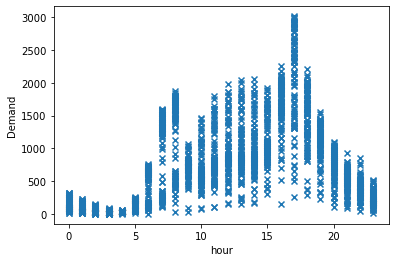

In [16]:
# note: we are using here the very powerful map() function, which returns a list of the results 
# after applying the given function to each item of a given iterable (list, tuple etc.)

plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Demand")
#plt.savefig('peak demand summer.png', dpi = 300)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = LinearRegression(fit_intercept =True)

In [18]:
model.fit(xp.values.reshape(-1,1),yp)
model_pred = model.predict(xp.values.reshape(-1,1))

In [19]:
xp.values

array([ 0.,  1.,  2., ..., 21., 22., 23.])

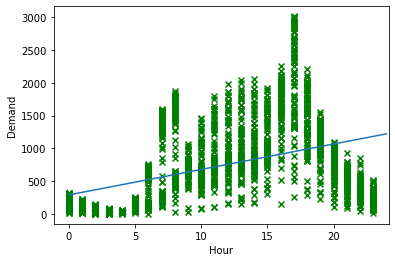

[38.78233951] 291.1972573833275
The R^2 of linear regression is:  0.1766275586837458


In [20]:
plt.scatter( xp ,yp, marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,24)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.show()
print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(yp, model_pred))

--> R^2 of 0.17 implies weak descriptive (hence also weak predictive power) of a linear model

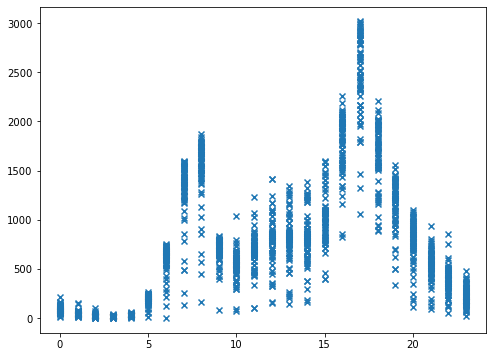

In [21]:
plt.figure(figsize = (8,6))
plt.scatter(df_summer[df_summer["IsWeekday"]==True]["hour"], 
            df_summer[df_summer["IsWeekday"]==True]["demand"], marker='x', color='C0')

During the weekday we can observe (as expected) peak demands at the commuting times of 7-8 am and 5pm. 

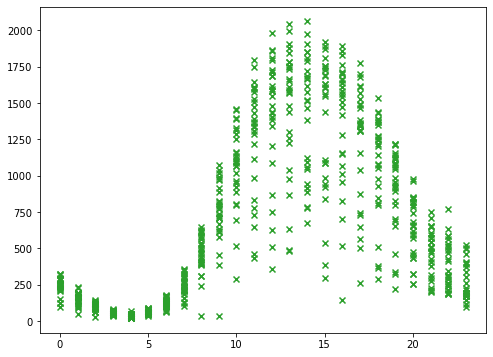

In [22]:
plt.figure(figsize = (8,6))
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["hour"], 
            df_summer[df_summer["IsWeekday"]==False]["demand"], marker='x', color='C2')

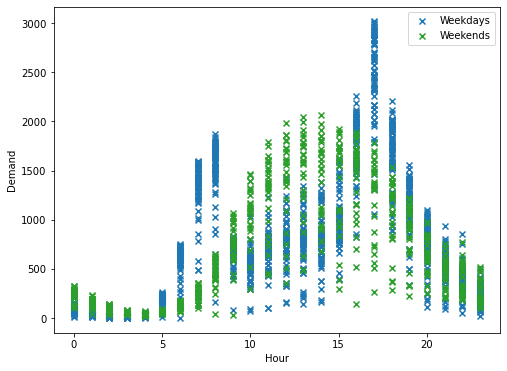

In [23]:
plt.figure(figsize = (8,6))
plt.scatter(df_summer[df_summer["IsWeekday"]==True]["hour"], 
            df_summer[df_summer["IsWeekday"]==True]["demand"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["hour"], 
            df_summer[df_summer["IsWeekday"]==False]["demand"], marker='x', color='C2')

plt.xlabel("Hour")
plt.ylabel("Demand")
plt.legend(["Weekdays", "Weekends"])
plt.show()

In [24]:
X = df_summer[["hour", "IsWeekday"]]
y = df_summer[["demand"]]
lin_mod_day = LinearRegression()
lin_mod_day.fit(X,y)
y_pred = lin_mod_day.predict(X)

print(lin_mod_day.coef_, lin_mod_day.intercept_)
print ('The R^2 of linear regression is: ',r2_score(y, y_pred))

[[38.76237261 61.71552366]] [247.7970789]
The R^2 of linear regression is:  0.1785687642316005


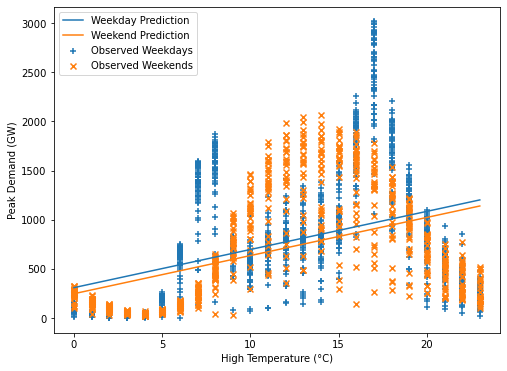

In [25]:
X_weekday = X[X["IsWeekday"]==1]
X_weekend = X[X["IsWeekday"]==0]

# predict weekends and weekdays seperately
y_pred_weekday = lin_mod_day.predict(X_weekday)
y_pred_weekend = lin_mod_day.predict(X_weekend)

plt.figure(figsize = (8,6))

plt.scatter(X_weekday["hour"], 
            df_summer[df_summer["IsWeekday"]==True]["demand"], 
            marker="+", label="Observed Weekdays")

plt.scatter(X_weekend["hour"], 
            df_summer[df_summer["IsWeekday"]==False]["demand"], 
            marker="x", label="Observed Weekends")

plt.plot(X_weekday["hour"], 
         y_pred_weekday, 
         label="Weekday Prediction")
plt.plot(X_weekend["hour"], 
         y_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")

plt.legend()
plt.show()

Splitting the data into weekdays and weekend and performing linear regression on these does not yield useful improvements in descriptive power. 

### Polynomial Regression

In [26]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    #Scaling data using min-max method
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    
    #Creating Polynomial features
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    #Solving normal equation and finding coefficients
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_reg_'+str(d)+'.png', dpi = 300)

We first perform a polynomial regression on the whole dataset, without segmentation in 1) weekday and 2) weekends.

[-311.74691937 -286.04255574 -894.85313663 -741.01114092]


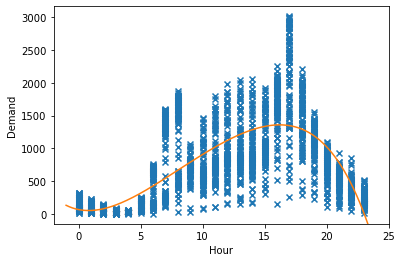

In [27]:
plot_regression_poly(x = xp, y=yp, d = 5)
#plt.savefig('test'.png', dpi = 1200)

[-19292.63142562   8764.49568625  44666.95696071 -15338.59693582]


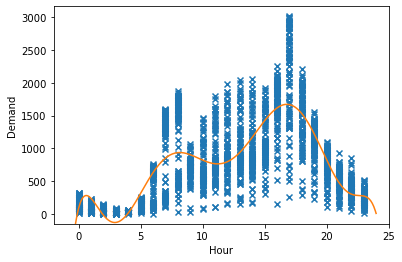

In [28]:
plot_regression_poly(x = xp, y=yp, d = 8)

###### -- Regression for: Weekday

For the weekdays, we expect 2 different (local) peaks at: 1) 7-8am and 2) 5-6pm and related dips in between at 3) lunch hours around 12am - 2pm and 4) during the night). Our first guess might be a d = 4 degree polynomial.

In [29]:
xp_weekday = df_summer[df_summer["IsWeekday"]==True]["hour"]
yp_weekday = df_summer[df_summer["IsWeekday"]==True]["demand"]

xp_weekend = df_summer[df_summer["IsWeekday"]==False]["hour"]
yp_weekend = df_summer[df_summer["IsWeekday"]==False]["demand"]

For the weekdays, we expect 2 different (local) peaks at: 1) 7-8am and 2) 5-6pm and related dips in between (especially 3) lunch hours around 12am - 2pm and 4) during the night). Our first guess might be a d = 4 degree polynomial.

[-1091.53094216 -1177.16868623    21.49716255  1225.24604973]


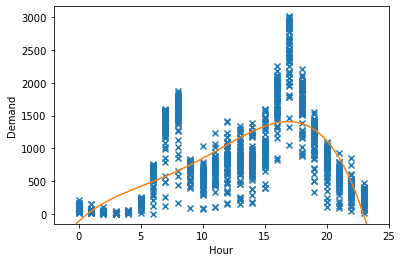

In [30]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 4)

This does not sufficiently catch the complexity and patterns we want to model with above mentioned qualitative prior knowledge. So we increase the degree of the regression polynomial.

[ 10408.63587633  -1135.41935683 -16258.76236036    177.38286861]


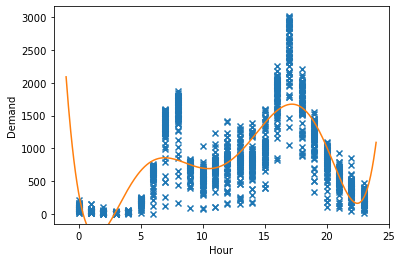

In [31]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 6)

[-29282.29257283  12346.13053925  67926.4364461  -22299.32824219]


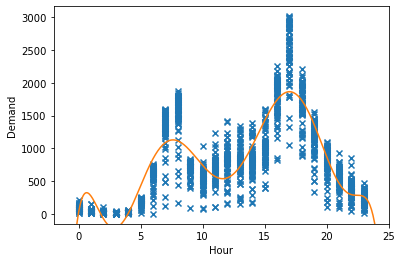

In [32]:
plot_regression_poly(x = xp_weekday, y=yp_weekday, d = 8)

d = 8 captures the demand on weekdays sufficiently well (graphically, quantitatve evaluation in the next section).

##### -- Regression for: Weekend

For the (on 1st glance, as seen above) less complex/fluctuating patterns of weekend demand, we expect a lower than d = 8 polynomial to be sufficient. 

[-1484.32578932 -1049.17088123  1373.56370712  1069.96396801]


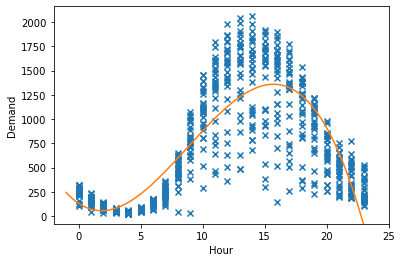

In [33]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 3)

[ 1652.02824563 -1478.64991498 -2576.88256625  1370.89263037]


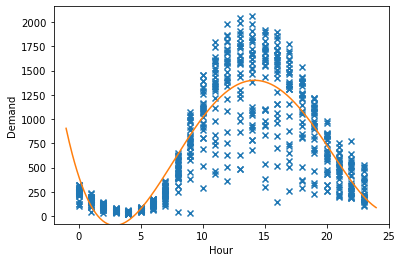

In [34]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 4)

[ 1666.19655922  1657.88783197 -3467.9428108  -2581.80561103]


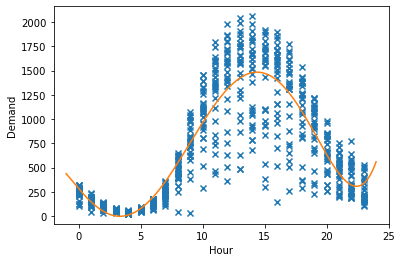

In [35]:
plot_regression_poly(x = xp_weekend, y=yp_weekend, d = 5)

As expected, a lower degree polynomial (d = 5) yields accurate graphical results in comparison to the weekday prediction.

##### - Regression for specific weather conditions: Sun (Precip = 0)

In [36]:
xp_sun = df_summer[df_summer["precip"]==0]["hour"]
yp_sun = df_summer[df_summer["precip"]==0]["demand"]

xp_rainsnow = df_summer[df_summer["precip"]==1]["hour"]
yp_rainsnow = df_summer[df_summer["precip"]==1]["demand"]

[ -262.13294518 -1276.95897411  -775.00057149  1279.01988458]


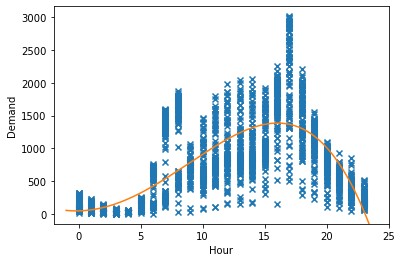

In [37]:
plot_regression_poly(x = xp_sun, y=yp_sun, d = 4)

[  6719.25634914   -315.67290194 -10051.30117675   -900.12580388]


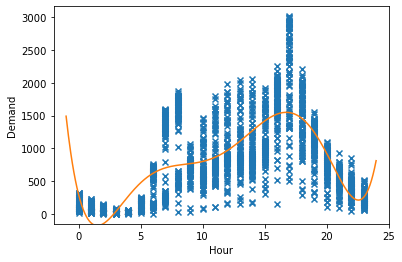

In [38]:
plot_regression_poly(x = xp_sun, y=yp_sun, d = 6)

##### - Regression for specific weather conditions: Rain/Snow (Precip = 1) 

[-600.22561837 -928.50255985 -230.93426403  937.90511814]


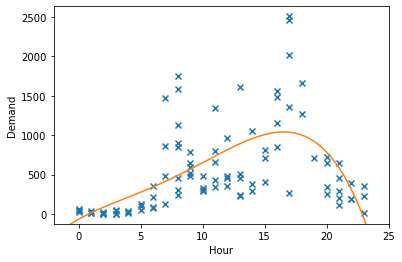

In [39]:
plot_regression_poly(x = xp_rainsnow, y=yp_rainsnow, d = 4)

[  7270.52017606   -536.68924361 -11255.70696033   -294.34680374]


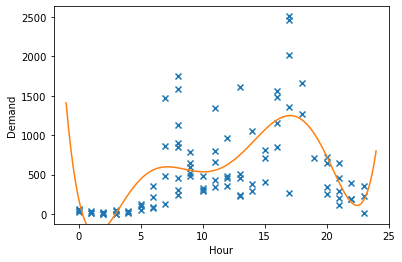

In [40]:
plot_regression_poly(x = xp_rainsnow, y=yp_rainsnow, d = 6)

The predictive results yield similar function behavior (also w.r.t. increases to the polynomial degree) in both cases. This could be interpreted that in the case of 2019's data there could not be observed significant differences for demand behaviour when comparing sunny to rainy/snow days. 

##### Cross-Validation

In [41]:
X = np.array([df_agg_h["hour"].values, np.ones(len(df_agg_h))], dtype=object).T
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df_agg_h["hour"].iloc[idx_train].values, df_agg_h["demand"].iloc[idx_train].values
x_cv, y_cv = df_agg_h["hour"].iloc[idx_cv].values, df_agg_h["demand"].iloc[idx_cv].values

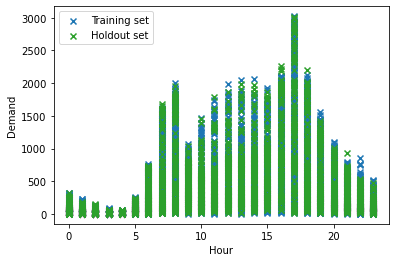

In [42]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.legend(['Training set', 'Holdout set'])

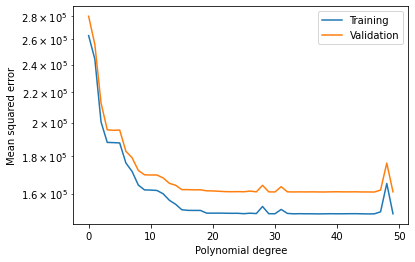

In [43]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.savefig('crossvalidation error .png', dpi = 500)

Text(0, 0.5, 'Mean squared error')

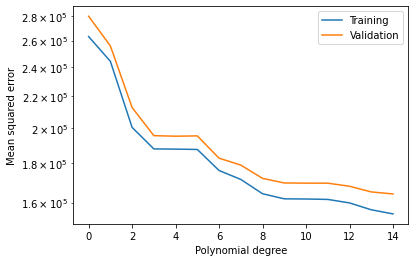

In [44]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

### Model improvements - Lever: L-2 Regularization

In [45]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    
    #xs = x
    
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    #xt = xt0 
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
      
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_Regularised reg_'+str(d)+'.png', dpi = 300)
    
    #return theta
   

[-19292.63142562   8764.49568625  44666.95696071 -15338.59693582]


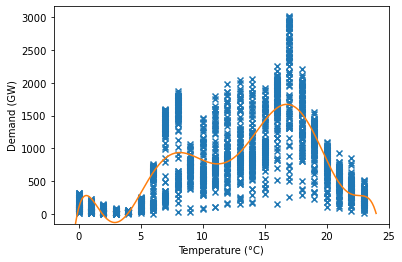

In [46]:
plot_regularized_polyregression(x = xp, y= yp, lam = 0, d = 8)

[ -8312.91567455   7562.50377541  22633.64122144 -13233.70064801]


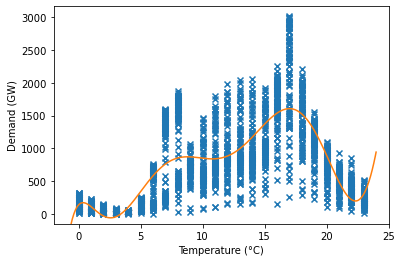

In [47]:
plot_regularized_polyregression(x = xp, y= yp, lam = 0.01, d = 8)

[ -1589.36929792   7190.57337412  12114.25443934 -13269.15763527]


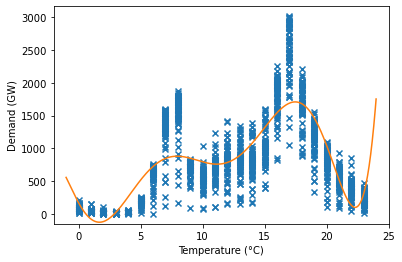

In [48]:
plot_regularized_polyregression(x = xp_weekday, y= yp_weekday, lam = 0.03, d = 8)

[ 2140.33038659   297.63608647  -449.89914403 -1299.61919722]


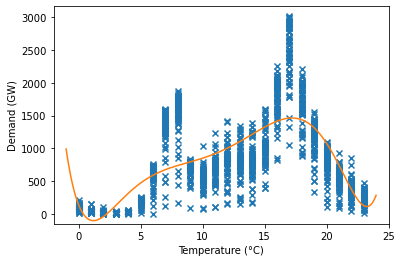

In [49]:
plot_regularized_polyregression(x = xp_weekday, y= yp_weekday, lam = 1, d = 8)

In [50]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

Text(0, 0.5, 'Coefficient weight')

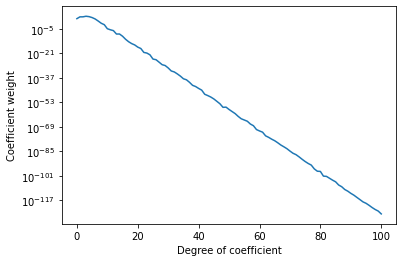

In [51]:
Theta = ls_poly_reg (x = xp, y= yp, lam = 10, degree = 100)
plt.semilogy(range(101), np.abs(Theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

In [52]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

lam = np.logspace(-15,10,100)

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

phi_train = poly_feat(x_train, 100)
phi_cv = poly_feat(x_cv,100)
err_train = [((phi_train @ ls_poly_reg(x_train, y_train, l, 100) - y_train)**2).mean() for l in lam]

#### Decision-Tree Regression

In [53]:
Xp = df_summer["hour"].values
Yp = df_summer["demand"].values

In [54]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="mse") # Other options: "friedman_mse", "mae"
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(0,24,1), Tree_reg.predict(np.arange(0,24,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("Hour", fontsize=16)
    plt.ylabel("Demand", fontsize=16)
    plt.semilogy
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(Yp, Y_pred))
    
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  23
number of leafs:  12
R^2:  0.6913033973084013


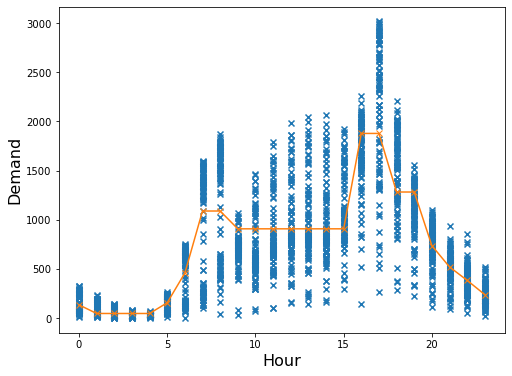

In [55]:
plot_tree_regression_line(4)

number of nodes:  39
number of leafs:  20
R^2:  0.729375023702879


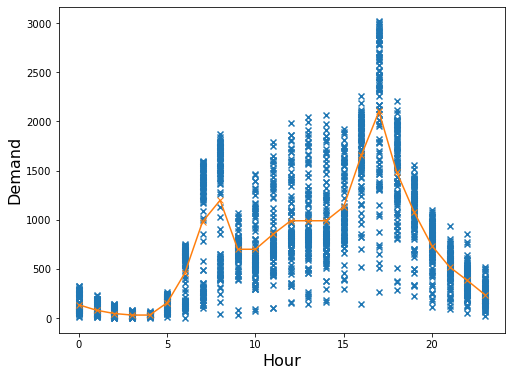

In [56]:
plot_tree_regression_line(6)

number of nodes:  47
number of leafs:  24
R^2:  0.7294222648931468


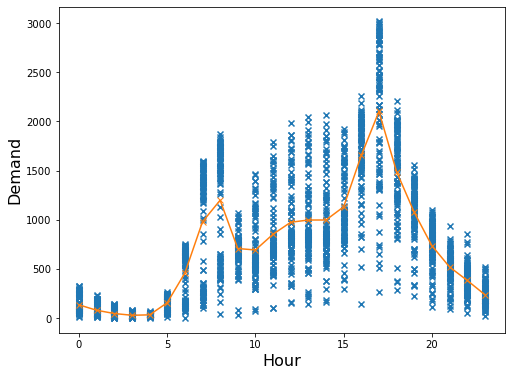

In [57]:
plot_tree_regression_line(8)

number of nodes:  47
number of leafs:  24
R^2:  0.7294222648931468


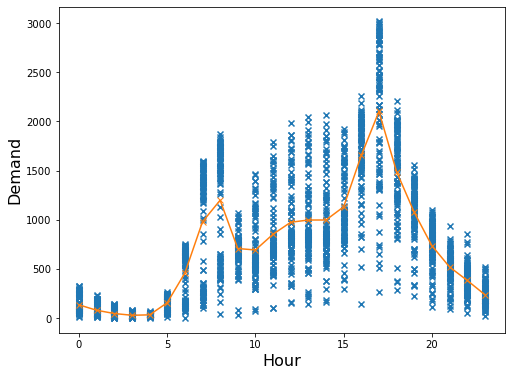

In [58]:
plot_tree_regression_line(100)

Model Evaluation: One can see that increasing the tree depths up to 8 also leads to useful increases in the R^2 such that the explanative power of the model increases. 
Further increasing the tree depths (example d = 100) does not lead to better predictions and R^2. 

The model building and evaluation of the results implies for use of predictive demand modeling:
1) A segmentation into Weekdays and Weekend which it's own distinct demand patterns (most namely due to commuting on work days) and predictions 
2) Polynomial regression or decision tree regression with regularization lead to precise predictions 